<a href="https://colab.research.google.com/github/christoph-fraller/dopp_2020w_group03_ex3/blob/main/dopp_2020w_group03_ex3_with_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate SSH-Keys for Accessing Git Repository

In [ ]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# generate ssh keys (insert your username@github.com + hit enter when prompted for any answer)
! ssh-keygen -t rsa -b 4096 -C 'michaelstitz@github.com'

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256://o6Tt7w9QoDHX0sEGZIX/GpE7DFeE5RCEPO7ZBOFGU michaelstitz@github.com
The key's randomart image is:
+---[RSA 4096]----+
|         .oO@E*o |
|          ==OO o.|
|           B*oo.+|
|          o.oooo |
|        S ...+   |
|         . .  .  |
|          + o .  |
|         o.= + . |
|         .=== ...|
+----[SHA256]-----+


In [ ]:
# check whether or not the ssh keys have been created ('id_rsa' and 'id_rsa.pub' should be displayed)
! ls /root/.ssh/

id_rsa	id_rsa.pub


In [ ]:
# create directory for saving the ssh keys
! mkdir -p /content/drive/MyDrive/Ssh

In [ ]:
# copy ssh keys from /root/.ssh/* to /content/drive/MyDrive/Ssh/*
! cp /root/.ssh/id_rsa /content/drive/MyDrive/Ssh/
! cp /root/.ssh/id_rsa.pub /content/drive/MyDrive/Ssh/

In [ ]:
# display public ssh key for copy/paste
! cat /content/drive/MyDrive/Ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDPd8zpuwQEJtEnd4wmZj+1QWgwwRURyzYGVDaw/Bk72NNBL65S+Ia4EGmvCmNy5Px0xCiZ5N+zF8G+8xY5lxx23pug8DdDppfpLaeDaxT9NJb8K0YQosvQTGc03gme1HhcbgObpRYyAwRJi/YsTyXCrbfG9awA2mi6ZVqIWncCE0GmqVJ0Rjs8lOf72kv0PK4v+YbfkIiDBUB4dSZ7niN6KcDb123bLzCpBv3GS4aR82CI3nA8PSrdp3n474zLQp/fllwS1yUD0HOPc2vHslP54COWNqubtaApgSi6F9QNRmrzG+zOI0pDigNAFwvKiCd6RAFSm0i9cjftl05Ee7302onXsrtHxM+Ta7TQ7rxn48fOh8FZNC0EHC1qXdc5y7hrbprdEj6msWJz/sUSv0HpRbt+mma9x6zwv87bgPVC8S6MubWvPzgS3/9x6vTa2oCb7dtj61XjTu1uU2tzck4aCZW6VoaAUrKNf19r7ORbZ+Sa7A6AdTNRL6EmHdHOLAUv+oFHXgOu8gbE7s8lGqPg3AtHvEy7Sr8qP+5st/wc9Cb8hdEcr94x/Y+EJ9Ic1m1FtKyJz3Os7Mbss4nVMclb0Gav0I82jDkf/v2rpB1q4Wygg73pz4ONFuYLQGfHeFcsSyZNCnc9/9KNEW/jsA+IDADvXcooFzVgcGGtNo6VGw== michaelstitz@github.com


In [ ]:
# add github to known hosts and adapt file access permissions
! ssh-keyscan github.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts
! chmod 600 /root/.ssh/id_rsa
! ssh -T git@github.com

# github.com:22 SSH-2.0-babeld-78794f53
# github.com:22 SSH-2.0-babeld-78794f53
# github.com:22 SSH-2.0-babeld-78794f53
git@github.com: Permission denied (publickey).


# Git Setup

In [ ]:
# git config settings (replace with your credentials)
! git config --global user.email "michaelstitz@gmail.com"
! git config --global user.name "michaelstitz"

In [ ]:
# create directory for git repositories
! mkdir -p /content/drive/MyDrive/Git

In [ ]:
# git-clone has to be performed only once when setting up the git repo at your google drive
! git clone git@github.com:christoph-fraller/dopp_2020w_group03_ex3.git /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

Cloning into '/content/drive/MyDrive/Git/dopp_2020w_group03_ex3'...
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


## Important Shell and Git Commands

**NOTICE:** Always ensure that you are in the right directory when performing git commands (e.g. /content/drive/MyDrive/Git/dopp_2020w_group03_ex3). In case of any issues that might occur when switching directories it is highly recommended to restart the runtime engine (CTRL + M + .).

In [ ]:
# check current working directory
! pwd

/content


In [ ]:
# switch to specified working directory
%cd /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

[Errno 2] No such file or directory: '/content/drive/MyDrive/Git/dopp_2020w_group03_ex3'
/content


In [ ]:
# list content of current working directory
! ls

sample_data


In [ ]:
# check git status
! git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# always perform a git pull before you start working or commit/push some changes
! git pull

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# add a new data file to git repo directly from colab
# at first upload the file into the folder of your google drive
# ! git add data/world_bank_income_level_thresholds.csv
# ! git commit -m 'New file added.'
# ! git push

[main 5f5e270] New file added.
Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.20 KiB | 307.00 KiB/s, done.
Total 6 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), done.
To github.com:christoph-fraller/dopp_2020w_group03_ex3.git
   3e96cae..5f5e270  main -> main


# Perform these steps everytime when a new session has been started

In [1]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# create directory
! mkdir -p /root/.ssh

In [3]:
# copy ssh keys from /content/drive/MyDrive/Ssh/* to /root/.ssh/*
! cp /content/drive/MyDrive/Ssh/id_rsa /root/.ssh/
! cp /content/drive/MyDrive/Ssh/id_rsa.pub /root/.ssh/ 

In [4]:
# add github to known hosts and adapt file access permissions
! ssh-keyscan github.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts
! chmod 600 /root/.ssh/id_rsa
! ssh -T git@github.com

# github.com:22 SSH-2.0-babeld-78794f53
# github.com:22 SSH-2.0-babeld-78794f53
# github.com:22 SSH-2.0-babeld-78794f53
Hi christoph-fraller/dopp_2020w_group03_ex3! You've successfully authenticated, but GitHub does not provide shell access.


In [5]:
# switch to specified working directory
%cd /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

/content/drive/MyDrive/Git/dopp_2020w_group03_ex3


In [53]:
# always perform a git pull before you start working or commit/push some changes
! git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From github.com:christoph-fraller/dopp_2020w_group03_ex3
   36479b5..cfbf3a9  main       -> origin/main
Updating 36479b5..cfbf3a9
Fast-forward
 data/undata_gni_per_capita.csv | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Data Preprocessing

###Load the data

source: World Bank

In [12]:
def load_csv_data():
    
    data_file = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/data_indicators_1.csv', sep = ',')

    return data_file

data = load_csv_data()

In [13]:
data

,Time,Time Code,Country Name,Country Code,"GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]","Population, total [SP.POP.TOTL]","Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative) [SE.PRM.CUAT.ZS]","Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]","Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]",Total natural resources rents (% of GDP) [NY.GDP.TOTL.RT.ZS],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Access to electricity (% of population) [EG.ELC.ACCS.ZS],Gini index (World Bank estimate) [SI.POV.GINI],Consumer price index (2010 = 100) [FP.CPI.TOTL],External balance on goods and services (% of GDP) [NE.RSB.GNFS.ZS],"Central government debt, total (% of GDP) [GC.DOD.TOTL.GD.ZS]"
0,1960,YR1960,Argentina,ARG,..,20481779,..,3.109,..,..,..,73.611,..,..,..,2.12913319746322E-06,..
1,1960,YR1960,Australia,AUS,..,10276477,..,3.453,..,..,..,81.529,..,..,7.96045785639958,-1.067036411864,..
2,1960,YR1960,Brazil,BRA,..,72179226,..,6.061,..,17.6669984863859,..,46.139,..,..,..,-0.0582390668087098,..
3,1960,YR1960,China,CHN,..,667070000,..,5.756,..,23.1752941976736,..,16.203,..,..,..,-0.122440650295898,..
4,1960,YR1960,France,FRA,..,46621669,..,2.85,..,10.5372165520776,..,61.88,..,..,10.4335934118144,2.43412905154375,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13240,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.tail(15)

,Time,Time Code,Country Name,Country Code,"GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]","Population, total [SP.POP.TOTL]","Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative) [SE.PRM.CUAT.ZS]","Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]","Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]",Total natural resources rents (% of GDP) [NY.GDP.TOTL.RT.ZS],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Access to electricity (% of population) [EG.ELC.ACCS.ZS],Gini index (World Bank estimate) [SI.POV.GINI],Consumer price index (2010 = 100) [FP.CPI.TOTL],External balance on goods and services (% of GDP) [NE.RSB.GNFS.ZS],"Central government debt, total (% of GDP) [GC.DOD.TOTL.GD.ZS]"
13227,2020,YR2020,Portugal,PRT,..,..,..,..,5.93300008773804,..,..,..,..,..,..,..,..
13228,2020,YR2020,Puerto Rico,PRI,..,..,..,..,8.41399955749512,..,..,..,..,..,..,..,..
13229,2020,YR2020,Qatar,QAT,..,..,..,..,0.0820000022649765,..,..,..,..,..,..,..,..
13230,2020,YR2020,Romania,ROU,..,..,..,..,3.92199993133545,..,..,..,..,..,..,..,..
13231,2020,YR2020,Rwanda,RWA,..,..,..,..,1.04100000858307,..,..,..,..,..,..,..,..
13232,2020,YR2020,Samoa,WSM,..,..,..,..,8.35499954223633,..,..,..,..,..,..,..,..
13233,2020,YR2020,San Marino,SMR,..,..,..,..,..,..,..,..,..,..,..,..,..
13234,2020,YR2020,Sao Tome and Principe,STP,..,..,..,..,13.6709995269775,..,..,..,..,..,..,..,..
13235,2020,YR2020,Senegal,SEN,..,..,..,..,6.67600011825562,..,..,..,..,..,..,..,..
13236,2020,YR2020,Serbia,SRB,..,..,..,..,12.7220001220703,..,..,..,..,..,..,..,..


### Drop unnecessary rows and columns

In [14]:
#drop rows
data.drop(data.tail(5).index,inplace=True)
#drop columns
data.drop(['Time Code','Country Code'], axis = 1, inplace=True)
#rename column Time to Year
data.rename(columns={'Time': 'Year'},inplace = True)


In [ ]:
#data.tail(15)

### Set index

In [15]:
data = data.set_index(['Country Name', 'Year'])
data

,,"GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]","Population, total [SP.POP.TOTL]","Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative) [SE.PRM.CUAT.ZS]","Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]","Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]",Total natural resources rents (% of GDP) [NY.GDP.TOTL.RT.ZS],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Access to electricity (% of population) [EG.ELC.ACCS.ZS],Gini index (World Bank estimate) [SI.POV.GINI],Consumer price index (2010 = 100) [FP.CPI.TOTL],External balance on goods and services (% of GDP) [NE.RSB.GNFS.ZS],"Central government debt, total (% of GDP) [GC.DOD.TOTL.GD.ZS]"
Country Name,Year,,,,,,,,,,,,,
Argentina,1960,..,20481779,..,3.109,..,..,..,73.611,..,..,..,2.12913319746322E-06,..
Australia,1960,..,10276477,..,3.453,..,..,..,81.529,..,..,7.96045785639958,-1.067036411864,..
Brazil,1960,..,72179226,..,6.061,..,17.6669984863859,..,46.139,..,..,..,-0.0582390668087098,..
China,1960,..,667070000,..,5.756,..,23.1752941976736,..,16.203,..,..,..,-0.122440650295898,..
France,1960,..,46621669,..,2.85,..,10.5372165520776,..,61.88,..,..,10.4335934118144,2.43412905154375,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samoa,2020,..,..,..,..,8.35499954223633,..,..,..,..,..,..,..,..
San Marino,2020,..,..,..,..,..,..,..,..,..,..,..,..,..
Sao Tome and Principe,2020,..,..,..,..,13.6709995269775,..,..,..,..,..,..,..,..


In [16]:
#drop Year 2020 since too little data available
data.drop('2020',level='Year',inplace=True)
data

,,"GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]","Population, total [SP.POP.TOTL]","Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative) [SE.PRM.CUAT.ZS]","Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]","Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]",Total natural resources rents (% of GDP) [NY.GDP.TOTL.RT.ZS],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Access to electricity (% of population) [EG.ELC.ACCS.ZS],Gini index (World Bank estimate) [SI.POV.GINI],Consumer price index (2010 = 100) [FP.CPI.TOTL],External balance on goods and services (% of GDP) [NE.RSB.GNFS.ZS],"Central government debt, total (% of GDP) [GC.DOD.TOTL.GD.ZS]"
Country Name,Year,,,,,,,,,,,,,
Argentina,1960,..,20481779,..,3.109,..,..,..,73.611,..,..,..,2.12913319746322E-06,..
Australia,1960,..,10276477,..,3.453,..,..,..,81.529,..,..,7.96045785639958,-1.067036411864,..
Brazil,1960,..,72179226,..,6.061,..,17.6669984863859,..,46.139,..,..,..,-0.0582390668087098,..
China,1960,..,667070000,..,5.756,..,23.1752941976736,..,16.203,..,..,..,-0.122440650295898,..
France,1960,..,46621669,..,2.85,..,10.5372165520776,..,61.88,..,..,10.4335934118144,2.43412905154375,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samoa,2019,4190,197097,..,..,8.35900020599365,9.75444952942173,..,18.056,..,..,117.555522119693,-14.6108154792665,..
San Marino,2019,..,33860,..,..,..,..,..,97.368,..,..,..,..,..
Sao Tome and Principe,2019,1930,215056,..,..,13.3690004348755,12.4625607991542,..,73.598,..,..,..,..,..


# Question 1

## Extract income data

In [17]:
income_data = data[['GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]', 'Population, total [SP.POP.TOTL]']]
income_data.reset_index(inplace = True)
income_data = income_data.rename(columns = {'Country Name' : 'country_name', 'Year' : 'calendar_year', 
                              'GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]' : 'gni_per_capita_us_dollar', 
                              'Population, total [SP.POP.TOTL]' : 'population_total'})
income_data['gni_per_capita_us_dollar'].replace('..', np.nan, inplace = True)
income_data['population_total'].replace('..', np.nan, inplace = True)
income_data['calendar_year'] = pd.to_numeric(income_data['calendar_year'])
income_data['gni_per_capita_us_dollar'] = pd.to_numeric(income_data['gni_per_capita_us_dollar'])
income_data['population_total'] = pd.to_numeric(income_data['population_total'])
income_data.set_index(['calendar_year'], inplace = True)
income_data

,country_name,gni_per_capita_us_dollar,population_total
calendar_year,,,
1960,Argentina,NaN,20481779.0
1960,Australia,NaN,10276477.0
1960,Brazil,NaN,72179226.0
1960,China,NaN,667070000.0
1960,France,NaN,46621669.0
...,...,...,...
2019,Samoa,4190.0,197097.0
2019,San Marino,NaN,33860.0
2019,Sao Tome and Principe,1930.0,215056.0


In [18]:
#search for countries with less than ... entries
#no_entries_countries = income_data['country_name','gni_per_capita_us_dollar'].groupby(['country_name']).value_counts(dropna = False)


## Load thresholds and sdr deflators


In [19]:
# load income-level thresholds
income_threshold_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/world_bank_income_level_thresholds.csv', sep = ',')
income_threshold_data.set_index(['calendar_year'], inplace = True)
income_threshold_data.drop(['banks_fiscal_year'], axis = 1, inplace = True)

# load sdr deflator values
sdr_deflator_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/world_bank_sdr_deflator.csv', sep = ',')
sdr_deflator_data.set_index(['calendar_year'], inplace = True)
sdr_deflator_data.drop(['sdr_deflator_us_dollar'], axis = 1, inplace = True)

# merge income_threshold_data and sdr_deflator_data using index 'calendar_year'
threshold_data = income_threshold_data.merge(sdr_deflator_data, how = 'inner', left_index = True, right_index = True)

In [20]:
threshold_data

,low_income_level_threshold,middle_income_level_threshold,high_income_level_threshold,sdr_inflation_rate_annual_change
calendar_year,,,,
1960,NaN,NaN,NaN,NaN
1961,NaN,NaN,NaN,1.1
1962,NaN,NaN,NaN,2.1
1963,NaN,NaN,NaN,1.4
1964,NaN,NaN,NaN,1.7
1965,NaN,NaN,NaN,2.7
1966,NaN,NaN,NaN,3.3
1967,NaN,NaN,NaN,3.2
1968,NaN,NaN,NaN,4.9


## Calculate missing thresholds using sdr deflators


In [21]:
def calculate_missing_thresholds(input_data):
    
    df = input_data
    thresholds_list = ['low_income_level_threshold', 'middle_income_level_threshold', 'high_income_level_threshold']   
    
    # calculate missing values
    for i in range(0, len(df)):
      # retrieve current index
      curr_index = df.index.max() - i
      for threshold in thresholds_list:
        # check if threshold value is missing
        if(np.isnan(df.loc[curr_index, threshold])):
          # calculate missing threshold value based on existing threshold and sdr_inflation_rate_annual_change
          df.loc[curr_index, threshold] = df.loc[curr_index + 1, threshold] / (100 + df.loc[curr_index + 1, 'sdr_inflation_rate_annual_change']) * 100
    
    # round thresholds to nearest multiple of base
    base = 5
    for threshold in thresholds_list:
      df[threshold] = round(df[threshold] / base) * base

    return df[thresholds_list]

threshold_data_complete = calculate_missing_thresholds(threshold_data)

In [22]:
threshold_data_complete

,low_income_level_threshold,middle_income_level_threshold,high_income_level_threshold
calendar_year,,,
1960,85.0,340.0,1050.0
1961,85.0,345.0,1060.0
1962,85.0,350.0,1085.0
1963,90.0,355.0,1100.0
1964,90.0,360.0,1115.0
1965,90.0,370.0,1150.0
1966,95.0,385.0,1185.0
1967,100.0,395.0,1225.0
1968,105.0,415.0,1285.0


In [23]:
merged_income_data = income_data.merge(threshold_data_complete, how = 'inner', left_index = True, right_index = True)
merged_income_data.loc[(merged_income_data['gni_per_capita_us_dollar'] <= merged_income_data['low_income_level_threshold']), 'income_level_label'] = 'low_income'
merged_income_data.loc[((merged_income_data['gni_per_capita_us_dollar'] > merged_income_data['low_income_level_threshold']) & 
                        (merged_income_data['gni_per_capita_us_dollar'] <= merged_income_data['middle_income_level_threshold'])), 'income_level_label'] = 'lower_middle_income'
merged_income_data.loc[((merged_income_data['gni_per_capita_us_dollar'] > merged_income_data['middle_income_level_threshold']) & 
                        (merged_income_data['gni_per_capita_us_dollar'] <= merged_income_data['high_income_level_threshold'])), 'income_level_label'] = 'upper_middle_income'
merged_income_data.loc[(merged_income_data['gni_per_capita_us_dollar'] > merged_income_data['high_income_level_threshold']), 'income_level_label'] = 'high_income'
merged_income_data

,country_name,gni_per_capita_us_dollar,population_total,low_income_level_threshold,middle_income_level_threshold,high_income_level_threshold,income_level_label
calendar_year,,,,,,,
1960,Argentina,NaN,20481779.0,85.0,340.0,1050.0,NaN
1960,Australia,NaN,10276477.0,85.0,340.0,1050.0,NaN
1960,Brazil,NaN,72179226.0,85.0,340.0,1050.0,NaN
1960,China,NaN,667070000.0,85.0,340.0,1050.0,NaN
1960,France,NaN,46621669.0,85.0,340.0,1050.0,NaN
...,...,...,...,...,...,...,...
2019,Samoa,4190.0,197097.0,1035.0,4045.0,12535.0,upper_middle_income
2019,San Marino,NaN,33860.0,1035.0,4045.0,12535.0,NaN
2019,Sao Tome and Principe,1930.0,215056.0,1035.0,4045.0,12535.0,lower_middle_income


## Replace missing values

In [24]:
merged_income_data.loc[merged_income_data['country_name'] == 'Argentina']



,country_name,gni_per_capita_us_dollar,population_total,low_income_level_threshold,middle_income_level_threshold,high_income_level_threshold,income_level_label
calendar_year,,,,,,,
1960,Argentina,NaN,20481779.0,85.0,340.0,1050.0,NaN
1961,Argentina,NaN,20817266.0,85.0,345.0,1060.0,NaN
1962,Argentina,NaN,21153052.0,85.0,350.0,1085.0,NaN
1963,Argentina,NaN,21488912.0,90.0,355.0,1100.0,NaN
1964,Argentina,1120.0,21824425.0,90.0,360.0,1115.0,high_income
1965,Argentina,1230.0,22159650.0,90.0,370.0,1150.0,high_income
1966,Argentina,1350.0,22494035.0,95.0,385.0,1185.0,high_income
1967,Argentina,1240.0,22828869.0,100.0,395.0,1225.0,high_income
1968,Argentina,1210.0,23168267.0,105.0,415.0,1285.0,upper_middle_income


## Calculating the population living in the different income levels

In [25]:
#Bin mir da noch nicht sicher ob ich da richtige Ergebnisse habe. Schaue mir das später nochmal an
#create sum of population of each income category for each year
population_income = pd.DataFrame()
population_income['low_income_population'] = merged_income_data['population_total'].loc[merged_income_data['income_level_label'] == 'low_income'].groupby('calendar_year').sum()
population_income['lower_middle_income_population'] = merged_income_data['population_total'].loc[merged_income_data['income_level_label'] == 'lower_middle_income'].groupby('calendar_year').sum()
population_income['upper_middle_income_population'] = merged_income_data['population_total'].loc[merged_income_data['income_level_label'] == 'upper_middle_income'].groupby('calendar_year').sum()
population_income['high_income_population'] = merged_income_data['population_total'].loc[merged_income_data['income_level_label'] == 'high_income'].groupby('calendar_year').sum()
population_income['unknown_income_population'] = merged_income_data['population_total'].loc[merged_income_data['income_level_label'] == np.nan].groupby('calendar_year').sum()

population_income


,low_income_population,lower_middle_income_population,upper_middle_income_population,high_income_population,unknown_income_population
calendar_year,,,,,
1962,6.959127e+08,7.567788e+08,2.928164e+08,2.848669e+08,NaN
1963,7.146545e+08,7.903836e+08,2.874632e+08,2.960641e+08,NaN
1964,7.296184e+08,8.208575e+08,2.446778e+08,3.735940e+08,NaN
1965,3.188031e+07,1.543733e+09,2.605319e+08,3.781080e+08,NaN
1966,3.291995e+07,1.667106e+09,2.674674e+08,3.823579e+08,NaN
1967,8.411253e+08,9.479199e+08,3.019071e+08,3.891561e+08,NaN
1968,1.393940e+09,4.596164e+08,2.306884e+08,4.755881e+08,NaN
1969,1.492354e+09,5.264472e+08,2.265788e+08,4.898122e+08,NaN
1970,1.571307e+08,1.913860e+09,2.373485e+08,5.629681e+08,NaN


## Visualisation

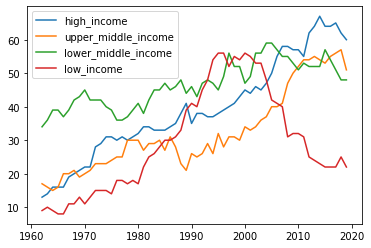

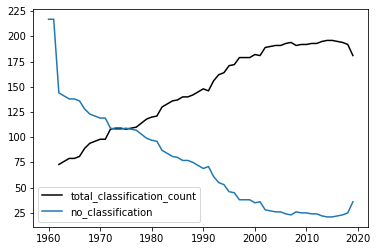

calendar_year  income_level_label 
1960           NaN                    217
1961           NaN                    217
1962           NaN                    144
               lower_middle_income     34
               upper_middle_income     17
                                     ... 
2019           high_income             60
               upper_middle_income     51
               lower_middle_income     48
               NaN                     36
               low_income              22
Name: income_level_label, Length: 292, dtype: int64

In [26]:
# merged_income_data['income_level_label'].loc[2019].hist()
# plt.show() 

# merged_income_data =  merged_income_data.loc[merged_income_data['population_total'] > 1000000.0]
# print(merged_income_data)
# print(merged_income_data[['population_total', 'income_level_label']].groupby(['calendar_year', 'income_level_label']).sum().groupby('calendar_year').sum())

#create df to show classification ###counts over time
income_classification_count = merged_income_data['income_level_label'].groupby('calendar_year').value_counts(dropna = False)

#plot income classification count over time
plt.plot(income_classification_count[:,'high_income'], label = 'high_income' )
plt.plot(income_classification_count[:,'upper_middle_income'], label = 'upper_middle_income')
plt.plot(income_classification_count[:,'lower_middle_income'], label = 'lower_middle_income')
plt.plot(income_classification_count[:,'low_income'], label = 'low_income')
plt.legend()
plt.show()

#plot total count of classification entries each year
income_classification_total_count = income_classification_count[:,'high_income']+income_classification_count[:,'upper_middle_income']+income_classification_count[:,'lower_middle_income']+income_classification_count[:,'low_income']
plt.plot(income_classification_total_count, label = 'total_classification_count', color = 'black')
plt.plot(income_classification_count[:,np.nan], label = 'no_classification')
plt.legend()
plt.show()

income_classification_count

In [123]:
#sb.heatmap(merged_income_data.isna(), cbar=False);
un_income_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/undata_gni_per_capita.csv', sep = ',')
country_list = un_income_data['country'].unique().tolist()
df = pd.DataFrame(columns = ['country', 'calendar_year'])
df.append({'country': 'Test', 'calendar_year': 2016}, ignore_index=True)
#for country in country_list:
  #for calendar_year in range(1970, 2019):
    #df.append([[country, calendar_year]])
un_income_data.set_index(['country', 'calendar_year'], inplace = True)
#un_income_data
un_population_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/undata_population_total.csv', sep = ',')
un_population_data.set_index(['country', 'calendar_year'], inplace = True)
un_population_data.drop_duplicates(inplace = True)
un_population_data['population_total'] = un_population_data['population_total'] * 1000
#un_population_data
#sb.heatmap(un_population_data.isna(), cbar=False);
#sb.heatmap(un_income_data.isna(), cbar=False);
merged_income_data = un_income_data.merge(un_population_data, how = 'inner', left_index = True, right_index = True)

#merged_income_data.count(level = 'country').unique()
un_income_data.reset_index(inplace = True)
un_population_data.reset_index(inplace = True)
un_population_data.reset_index().country.unique()
un_income_data.reset_index().country.nunique()
#un_population_data.reset_index().country.nunique()
un_income_data
#set(un_income_data.country).difference(un_population_data.country)
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China (Hong Kong SAR)',
 'China (Macao SAR)',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 "Côte d'Ivoire",
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethio

In [122]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), done.
From github.com:christoph-fraller/dopp_2020w_group03_ex3
   1e7311e..d0e97d7  main       -> origin/main
Updating 1e7311e..d0e97d7
Fast-forward
 data/undata_gni_per_capita.csv   |  156 ++--
 data/undata_population_total.csv | 1800 +++++++++++++++++++-------------------
 2 files changed, 978 insertions(+), 978 deletions(-)
